In [72]:
import numpy as np
import pandas as pd
import datetime
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [73]:
df = pd.read_csv('../data/aden_golfe_matrix_global.csv',sep=';')
df.head()
df['date'] = df.apply(lambda row: datetime.datetime.strptime(row['date'], "%Y-%m-%d"), axis=1)
df['Full_Years'] = df.apply(lambda row: row['Years']+(row['Month']/12), axis=1)
df.head()

,Count,Month,Years,date,Full_Years
0,0,1,2008,2008-01-01,2008.083333
1,2,2,2008,2008-02-01,2008.166667
2,3,3,2008,2008-03-01,2008.250000
3,6,4,2008,2008-04-01,2008.333333
4,6,5,2008,2008-05-01,2008.416667


# Time series prediction

date
2008-01-01    0
2008-02-01    2
2008-03-01    3
2008-04-01    6
2008-05-01    6
Name: Count, dtype: int64


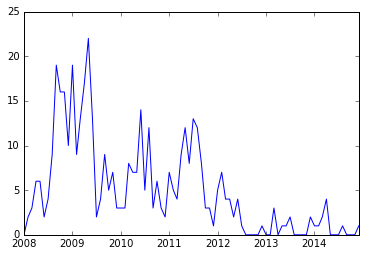

In [74]:
df2=df.set_index('date')
ts = df2['Count']
print ts.head(5)
plt.plot(ts)

In [75]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

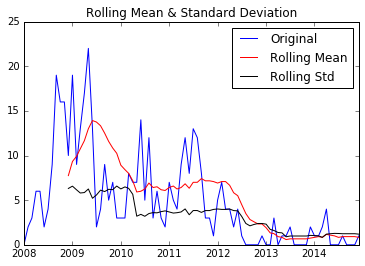

Results of Dickey-Fuller Test:
Test Statistic                 -2.660536
p-value                         0.081120
#Lags Used                      1.000000
Number of Observations Used    82.000000
Critical Value (5%)            -2.897490
Critical Value (1%)            -3.512738
Critical Value (10%)           -2.585949
dtype: float64


In [76]:
test_stationarity(ts)

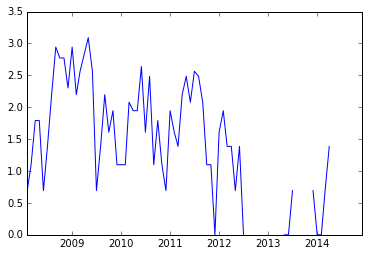

In [77]:
ts_log = np.log(ts)
plt.plot(ts_log)

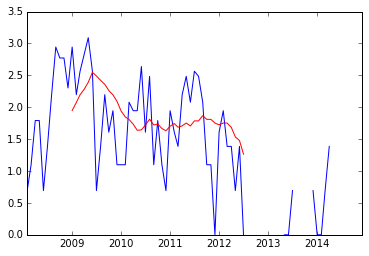

In [20]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

ValueError: You must specify a freq or x must be a pandas object with a timeseries index

# Time Series version 2

In [185]:
to_forecast = df['Count'].values
dates = df['Full_Years'].values
print df.head(30)

    Count  Month  Years       date   Full_Years
0       0      1   2008 2008-01-01  2008.083333
1       2      2   2008 2008-02-01  2008.166667
2       3      3   2008 2008-03-01  2008.250000
3       6      4   2008 2008-04-01  2008.333333
4       6      5   2008 2008-05-01  2008.416667
5       2      6   2008 2008-06-01  2008.500000
6       4      7   2008 2008-07-01  2008.583333
7       9      8   2008 2008-08-01  2008.666667
8      19      9   2008 2008-09-01  2008.750000
9      16     10   2008 2008-10-01  2008.833333
10     16     11   2008 2008-11-01  2008.916667
11     10     12   2008 2008-12-01  2009.000000
12     19      1   2009 2009-01-01  2009.083333
13      9      2   2009 2009-02-01  2009.166667
14     13      3   2009 2009-03-01  2009.250000
15     17      4   2009 2009-04-01  2009.333333
16     22      5   2009 2009-05-01  2009.416667
17     13      6   2009 2009-06-01  2009.500000
18      2      7   2009 2009-07-01  2009.583333
19      4      8   2009 2009-08-01  2009

In [177]:
import numpy as np

def organize_data(to_forecast, window, horizon):
    """
     Input:
      to_forecast, univariate time series organized as numpy array
      window, number of items to use in the forecast window
      horizon, horizon of the forecast
     Output:
      X, a matrix where each row contains a forecast window
      y, the target values for each row of X
    """
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast, shape=shape, strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

k = 20   # number of previous observations to use
h = 1  # forecast horizon
X,y = organize_data(to_forecast, k, h)

In [178]:
y[:m]

array([ 9,  5,  7,  3,  3,  3,  8,  7,  7, 14,  5, 12,  3,  6,  3,  2,  7,
        5,  4,  9, 12,  8, 13, 12,  8,  3,  3,  1,  5,  7,  4,  4,  2,  4,
        1,  0,  0,  0,  0,  1,  0,  0,  3,  0,  1,  1,  2,  0,  0,  0])

In [202]:
m = 50 # number of samples to take in account
regressor = LinearRegression(normalize=True)
regressor.fit(X[:m], y[:m])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [203]:
prediction_error=regressor.predict(X[m:])
prediction_error[prediction_error < 0] = 0
print prediction_error

[ 0.20265686  0.          0.43970239  1.4291552   0.07911371  0.73048482
  2.14124734  0.45590953  0.          0.          0.          0.          0.
  0.        ]


In [204]:
def mape(ypred, ytrue):
    """ returns the mean absolute percentage error """
    idx = ytrue != 0.0
    return 100*np.mean(np.abs(ypred[idx]-ytrue[idx])/ytrue[idx])

print 'The error is %0.2f%%' % mape(prediction_error,y[m:])

The error is 82.39%


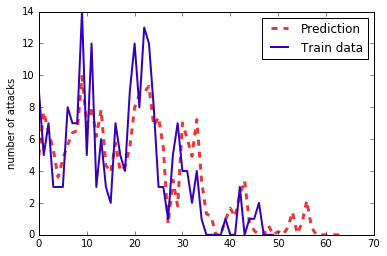

In [207]:
predictions=regressor.predict(X)
predictions[predictions < 0] = 0
#figure(figsize=(8,6))
#plt(y, label='True demand', color='#377EB8', linewidth=2)
plt.plot(predictions, '--', color='#EB3737', linewidth=3, label='Prediction')
plt.plot(y[:m], label='Train data', color='#3700B8', linewidth=2)
#plt.xticks(arange(len(dates))[1::4],dates[1::4], rotation=45)
#plt.axis([2008, 2015, 0, max(y[:m])])
#t = np.arange(2008, 2015, 1/12)
plt.legend(loc='upper right')
plt.ylabel('number of attacks')
plt.show()